# Visualisation
By the end of this lecture on you will be able to:
- create charts from Polars with the internal `plot` method
- create charts from Polars with external plotting libraries
- understand how these libraries support Polars

Up-to-date versions of the visualisation libraries are typically required for maximum compatibility

In [ ]:
%pip install -U polars

In [2]:
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt

In [3]:
csv_file = '../data/titanic.csv'

In [4]:
df = pl.read_csv(csv_file)
df.head(3)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,"""Braund, Mr. Owen Harris""","""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,"""Cumings, Mrs. John Bradley (Fl…","""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,"""Heikkinen, Miss. Laina""","""female""",26.0,0,0,"""STON/O2. 3101282""",7.925,null,"""S"""


We first look at whether we can pass a Polars `DataFrame` directly to each plotting library by creating a simple bar chart. Below we consider some other points to be aware of for working with each library from Polars.

## Bar chart

We begin by getting a count of the number of passengers in each passenger class. We use the `value_counts` method to count the occurences in the column. See the section of the course on Statistics and Aggregation for more on this method.

In [13]:
passenger_class_counts_df = (
    df['Pclass']
    .value_counts()
    .sort("Pclass")
)
passenger_class_counts_df

Pclass,count
i64,u32
1,216
2,184
3,491


In [14]:
(
    df
    .select("Pclass")
    .to_series()
).value_counts()

Pclass,count
i64,u32
1,216
2,184
3,491


## Built-in plotting with Altair
> Until v1.6.0 the built-in plotting was with HvPlot. From v1.6.0 the built-in plotting has been with Altair.

A `DataFrame` has a built-in `.plot` method that passes the `DataFrame` to the Altair library. 

Here we make a bar chart of the number of passengers in each class. Note that we cast `Pclass` from integer to string so that the column is treated like a categorical variable (see what happens if we pass it without this step as an integer)

In [15]:
(
    passenger_class_counts_df
    .with_columns(
        pl.col("Pclass").cast(pl.String)
    )
    .plot.bar(
        x="Pclass",
        y="count"
    )
    .properties(
        width=500
    )
)

ModuleUpgradeRequiredError: altair>=5.4.0 is required for `.plot`

If you hover over each bar you will see a `tooltip` which displays the name and height of the bar by default.

If you want to learn more about Altair then I recommend doing this tutorial to understand more about the key concepts: https://altair-viz.github.io/altair-tutorial/README.html

Thankfully, there is a less verbose way to manage the dtypes as we can use the [Altair system for encoding data types](https://altair-viz.github.io/user_guide/encodings/index.html#encoding-data-types) to override the default mapping from Polars dtype to Altair encoding.  These Altair encodings are:
- `Q` for quantitative data
- `O` for ordinal data
- `N` for categorical data
- `T` for datetime data

In this case we can say that the `Pclass` is ordinal data (though we could also say it is categorical). To tell Altair the `Pclass` should be treated as an ordinal variable we follow the column name with `:O`

In [ ]:
(
    passenger_class_counts_df
    .plot.bar(
        x="Pclass:O",
        y="count"
    )
    .properties(
        width=500
    )
)

Try changing the `:O` to the other encodings to see the effect on the chart.

The output of `plot.bar` is a normal Altair `Chart` object so we can use standard Altair methods to configure the chart. In the example we use `.properties` to set high-level properties such as the width and title of the chart

In [ ]:
(
    passenger_class_counts_df
    .plot
    .bar(
        x="Pclass:O",
        y="count",
        tooltip=["Pclass","count"]
    )
    .properties(
        width=500,
        title="Number of passengers by class"
    )
)

Be aware that the arguments to the plot method are Altair `Channel` objects rather than just column name strings. This means we can use Altair axis objects to apply more control over styling. 

Here for example:
- we use `alt.X` and `alt.Y` to add axis titles
- we use `alt.Tooltip` to override the default tooltip

In [ ]:
(
    passenger_class_counts_df
    .plot
    .bar(
        x=alt.X("Pclass:O",title="Passenger class"),
        y=alt.Y("count",title="Number of passengers"),
        tooltip=[
            alt.Tooltip("Pclass",title="Class"),
            alt.Tooltip("count",title="Number of passengers")
        ]
    )
    .properties(
        width=500
    )
)

In Altair we can also apply functions to transform or aggregate the data. Here for example we make the same bar chart directly from `df`. We do this by passing `Pclass` as the x-axis and `count()` as the y-axis

In [ ]:
(
    df
    .plot
    .bar(
        x=alt.X("Pclass:O",title="Passenger class"),
        y=alt.Y('count()', title='Number of Passengers'),
    )
    .properties(
        width=500
    )
)

The aggregation functions are set out here: https://altair-viz.github.io/user_guide/encodings/index.html#aggregation-functions.

If we pass the full dataset to Altair and it has more than 5000 rows we get the dreaded Altair MaxRowsLimit error. There [are ways around this](https://altair-viz.github.io/user_guide/large_datasets.html) such as turning off the limit or using [vegafusion](https://www.rhosignal.com/posts/polars-and-altair/).

I have used Altair for a number of years but I prefer to write normal functions to do any transformations or aggregations with Polars and then do relatively simple plots with Altair. This is mainly because the functions I write are testable and working with Altair data transformations can be hard to debug.


We can make a stacked bar chart with colours on each bar set by another column by adding the `color` argument. Here we colour the bars by the proportions that survived

In [ ]:
(
    df
    .plot
    .bar(
        x=alt.X("Pclass:O",title="Passenger class"),
        y=alt.Y('count()', title='Number of Passengers'),
        color=alt.Color('Survived:N',legend=alt.Legend(title='Survived')),
        tooltip=['Pclass', 'Survived', 'count()']
    )
    .properties(
        width=500
    )
)

We can make a stacked bar chart with colours on each bar set by another column by adding the `color` argument. Here we colour the bars by the proportions that survived

In [16]:
(
    df
    .plot
    .bar(
        x=alt.X("Pclass:O",title="Passenger class"),
        y=alt.Y('count()', title='Number of Passengers'),
        color=alt.Color('Survived:N',legend=alt.Legend(title='Survived')),
    tooltip=['Pclass', 'Survived', 'count()']
    )
    .properties(
        width=500
    )
)

ModuleUpgradeRequiredError: altair>=5.4.0 is required for `.plot`

### Scatter plot
In this example we do:
- a scatter plot of Age vs Fare
- with colour by Pclass
- add a tooltip (including the `Name` column that is not plotted)
- set the width of the plot
- set the title of the plot

In [ ]:
(
    df
    .plot
    .scatter(
        x="Age",
        y="Fare",
        color="Pclass:N",  
        tooltip=["Age","Fare","Pclass","Name"]
    )
    .properties(
        width=500,
        title="Age vs Fare"
    )
)

In this case `Pclass` is the colour. Try varying the encoding type of `Pclass` in this plot to see how it affects the colour scheme.

Note that the plots are interactive and we can pan or zoom the chart with mouse/trackpad movements 

We can control the colormap with the `configure_range` method and the Vega color schemas described here: https://vega.github.io/vega/docs/schemes/

In [ ]:
(
    df
    .with_columns(
        pl.col("Pclass").cast(pl.String)
    )
    .plot
    .scatter(
        x="Age",
        y="Fare",
        color="Pclass",  
        tooltip=["Age","Fare","Pclass","Name"]
    )
    .properties(
        width=500
    )
    .configure_range(
        category={'scheme': 'dark2'}
    )
)

You can see more examples of Altair plots here: https://altair-viz.github.io/gallery/index.html

### Histogram
We can make a histogram either from a `hist` expression on a `Series`

In [ ]:
(
    df["Age"]
    .hist(
        bin_count=10
    )
).head(2).to_dicts()

We then use either the `breakpoint` or `category` columns as the axis

In [ ]:
(
    df["Age"]
    .hist(
        bin_count=10
    )
    .plot
    .bar(
        x="category",
        y="count"
    )
)

Altair has native support for Polars via the [Narwhals package](https://github.com/narwhals-dev/narwhals). This package allows third-party packages to support different `DataFrame` libraries using the same API as described here: https://pola.rs/posts/lightweight_plotting/

## Plotting directly with external libraries
We can also pass a Polars `DataFrame` directly to external libraries.
### Matplotlib
We can pass the columns of the `passenger_class_counts_df` directly to Matplotlib

> I sometimes encounter problems with this chart and the Seaborn chart below not rendering. If you encounter this please let me know

<BarContainer object of 3 artists>

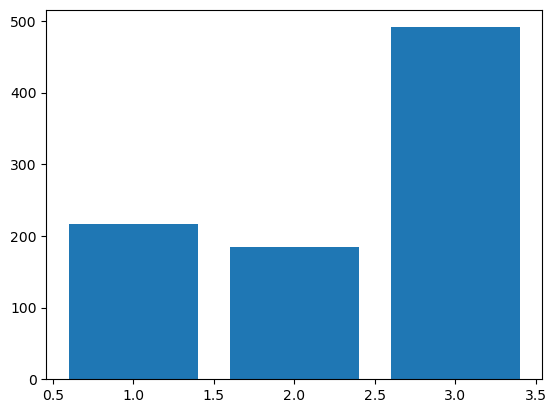

In [17]:
(
    plt.bar(
        x=passenger_class_counts_df["Pclass"],
        height=passenger_class_counts_df["count"]
    )
)

Note that the `Pclass` column is an integer column in Polars but the x-axis in the chart is a float axis. To make this appear as an categorical integer axis we cast the integers to strings

<BarContainer object of 3 artists>

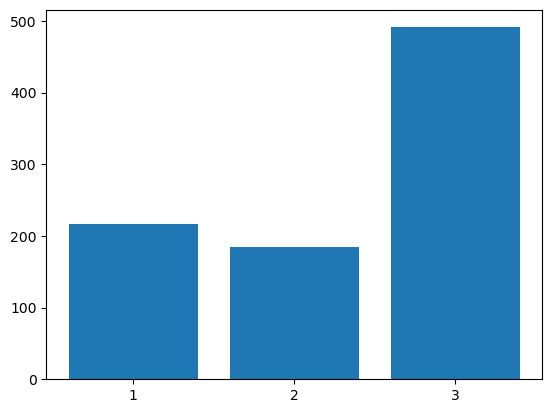

In [18]:
passenger_class_counts_string_column_df = (
    passenger_class_counts_df
    .with_columns(
        pl.col("Pclass").cast(pl.Utf8)
    )
)
(
    plt.bar(
        x=passenger_class_counts_string_column_df["Pclass"],
        height=passenger_class_counts_string_column_df["count"]
    )
)

Matplotlib does not have explicit support for Polars. However, Matplotlib can accept a Polars `Series` as it just needs sequence-type objects that it can iterate through using standard python methods (that a `Series` supports).

### Seaborn
We can pass a Polars `DataFrame` to Seaborn for many charts. Note that Seaborn then typically copies the data to Pandas internally as it makes extensive use of Pandas-specific features such as the index. With a large `DataFrame` you may want to only pass the columns needed for the plot to avoid the whole `DataFrame` being copied!

<Axes: xlabel='Pclass', ylabel='count'>

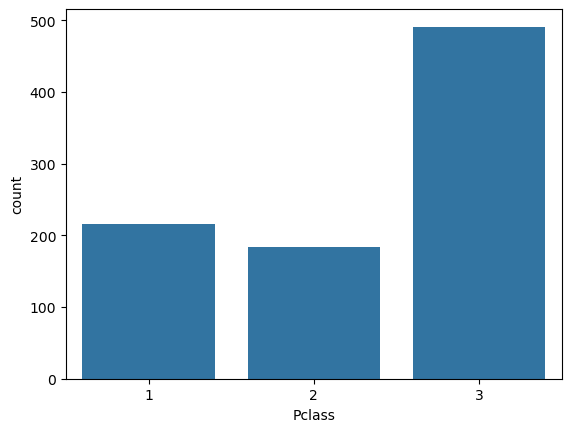

In [19]:
(
    sns.barplot(
        passenger_class_counts_df,
        x="Pclass",
        y="count"
    )
)

Some more complicated Seaborn charts also accept a Polars `DataFrame` directly such as `sns.scatterplot` or `sns.jointplot`. In this example we do a joint plot of (log) Age and (log) Fare coloured by passenger class

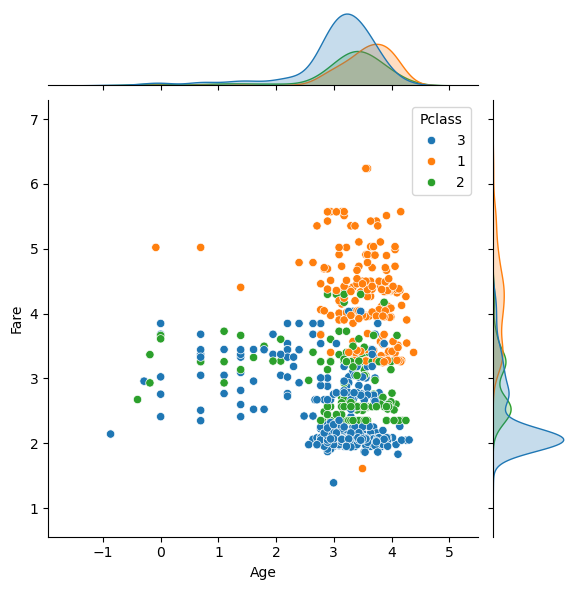

In [20]:
(
    sns.jointplot(
        data=(
            df
            .with_columns(
                [
                    pl.col(pl.Float64).log(),
                    pl.col("Pclass").cast(pl.Utf8)
                ]
            )
        ),
        x="Age", 
        y="Fare", 
        hue="Pclass",
    )
)

### Plotly
We can pass a `DataFrame` directly to Plotly - note that we again use the `DataFrame` with a string column for correct output (ignore any Pandas warnings from the Plotly internals)

In [21]:
(
    px.bar(
        passenger_class_counts_string_column_df,
        x="Pclass",
        y="count",
        color="Pclass",
        width=400
    )
)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'Pclass=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '1',
              'marker': {'color': '#636efa', 'pattern': {'shape': ''}},
              'name': '1',
              'offsetgroup': '1',
              'orientation': 'v',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['1'], dtype=object),
              'xaxis': 'x',
              'y': array([216], dtype=uint32),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': 'Pclass=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '2',
              'marker': {'color': '#EF553B', 'pattern': {'shape': ''}},
              'name': '2',
              'offsetgroup': '2',
              'orientation': 'v',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['2'], dtype=object),
              'xaxis': 'x',
              'y': array([184], dtype=uint32),
              'yaxis': 'y'},
             {'alignmentgroup': 'True',
              'hovertemplate': 'Pclass=%{x}<br>count=%{y}<extra></extra>',
              'legendgroup': '3',
              'marker': {'color': '#00cc96', 'pattern': {'shape': ''}},
              'name': '3',
              'offsetgroup': '3',
              'orientation': 'v',
              'showlegend': True,
              'textposition': 'auto',
              'type': 'bar',
              'x': array(['3'], dtype=object),
              'xaxis': 'x',
              'y': array([491], dtype=uint32),
              'yaxis': 'y'}],
    'layout': {'barmode': 'relative',
               'legend': {'title': {'text': 'Pclass'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'width': 400,
               'xaxis': {'anchor': 'y',
                         'categoryarray': [1, 2, 3],
                         'categoryorder': 'array',
                         'domain': [0.0, 1.0],
                         'title': {'text': 'Pclass'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'count'}}}
})

### Altair
We can pass a `DataFrame` directly to Altair

In [22]:
(
    alt.Chart(
        passenger_class_counts_df,
        width=600
    )
    .mark_bar()
    .encode(
        x="Pclass:N",
        y="count:Q",
        color="Pclass:N",
    )
)

alt.Chart(...)

## Exercises
In the exercises you will develop your understanding of:
- creating charts from Polars

### Exercise 1
We first create a `DataFrame` of bike sales and replace spaces in the string column names with `_` (see the lecture on Transforming DataFrames in the section of selecting and transforming data for more on `pipe`)

In [ ]:
df_bike = (
    pl.read_parquet("../data/bike_sales.parquet")
    .pipe(lambda df: df.rename({col:col.replace(" ","_") for col in df.columns}))
)
df_bike.head(2)

We do a `group_by` first to get the data

In [ ]:
customer_count_df = (
    df_bike
    .group_by("customer_age",maintain_order=True)
    .len()
    .sort("customer_age")
)
customer_count_df

Using the built-in plot method make a bar chart of the `customer_age` column showing the number of bikes sold by customer_age.

For the next exercise we disable the max rows limit in Altair so we can do calculations on the 25000 rows in `df_bike`

In [ ]:
import altair as alt
alt.data_transformers.disable_max_rows()

<blank>

Make the same plot directly from `df_bike` but this time using Altair to do the counting

Instead of a count of rows do a sum of the revenue column. Do this as a stacked bar chart coloured by `sub_category` of bike

## Solutions
Using the built-in plot method and your preferred visualisation library make a bar chart of the `customer_age` column showing the number of bikes sold by customer_age.

In [ ]:
(
    customer_count_df
    .plot
    .bar(
        x=alt.X("customer_age:O",title="Customer age"),
        y=alt.Y("len",title="Number of bikes sold")
    )
    .properties(
        width=1000
    )
)

Make the same plot directly from `df_bike` using Altair to do the counting

In [ ]:
(
    df_bike
    .plot
    .bar(
        x=alt.X("customer_age:O",title="Customer age"),
        y=alt.Y("count()",title="Number of bikes sold")
    )
    .properties(
        width=700
    )
)

Instead of a count of rows do a sum of the revenue column. Do this as a stacked bar chart coloured by `sub_category` of bike

In [ ]:
(
    df_bike
    .plot
    .bar(
        x=alt.X("customer_age:O",title="Customer age"),
        y=alt.Y("sum(revenue)",title="Total revenue"),
        color="sub_category"
    )
    .properties(
        width=700
    )
)

The solutions for the basic bar chart are shown for the other libraries here.

### Matplotlib

In [ ]:
plt.bar(
    x=customer_count_df["customer_age"],
    height=customer_count_df["len"],
)

### Seaborn

In [ ]:
sns.barplot(
    customer_count_df.to_pandas(use_pyarrow_extension_array=True),
    x="customer_age",
    y="len"
)

### Plotly

In [ ]:
px.bar(
    customer_count_df.with_columns(pl.col("customer_age").cast(pl.Utf8)),
    x="customer_age",
    y="len",
)

### Altair

In [ ]:
(
    alt.Chart(
    customer_count_df,
        width=600
    )
    .mark_bar()
    .encode(
        x="customer_age:N",
        y="len:Q"
    )
)